<a href="https://colab.research.google.com/github/mikgroup/bpt_mrpub/blob/main/plot_accel_bpt_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

import sys

import sigpy.plot as pl

# Data I/O
sys.path.append("/mikRAID/sanand/pilot_tone/bpt/util")
import cfl

# BPT processing libraries
sys.path.append("/mikRAID/sanand/pilot_tone/bpt")
from get_bpt import *
from run_bpt import *
from plot_bpt import *
import bpt_processing as proc
from util.detect_peaks import detect_peaks

from scipy import signal
import scipy
from scipy.optimize import lsq_linear, nnls
import scipy.integrate as integ

# Plot params

In [ ]:
# Reset to default
plt.rcParams.update(matplotlib.rcParamsDefault)

In [ ]:
# Custom plot parameters for ISMRM figures
plt.rcParams.update({'axes.spines.right':False,
                     'axes.spines.left':False,
                    'axes.spines.top':False,
                    'axes.titlesize':20, # fontsize of the axes title
                    'axes.labelsize':18,
                    'legend.fontsize':18,
                    'xtick.labelsize':16,
                    'ytick.labelsize':16,
                     'lines.linewidth':2
                    })

# Functions

In [ ]:
def get_accel_data(inpdir, fname=None):
    ''' Load accelerometer data from file '''
    # Load fname as file that starts with 'data'
    if fname is None:
        fname = [f for f in os.listdir(inpdir) if f.startswith('data')][0]
    data = np.loadtxt(os.path.join(inpdir,fname))
    t = data[:,0]*1e-6 # seconds
    x = data[:,1]
    y = data[:,2]
    z = data[:,3]
    accel = np.vstack([x,y,z]).T
    return accel[1:,:],t # Return in the same shape as BPT

def dbl_int(accel, tr=8.7e-3, cutoff=1, get_v=False):
    ''' Double integrate acceleration -> displacement '''
    # Filter out fluctuations in accelerometer signal
    accel_filt = proc.filter_sig(accel, cutoff=cutoff, fs=1/tr, order=6, btype='high')
    accel_v = integ.cumtrapz(accel_filt, dx=tr, initial=0)
    accel_d = integ.cumtrapz(proc.normalize(accel_v, var=False), dx=tr, initial=0)
    if get_v is True: # Get velocity
        return accel_d, accel_v
    else:
        return accel_d

def get_accel_d(accel, tr=8.7e-3, cutoff=3, get_v=False):
    ''' Get integrated acceleration -> displacement for all axes '''
    accel_d = np.empty((accel.shape[0],3))
    if get_v is True:
        # Optionally get velocity
        accel_v = np.empty((accel.shape[0],3))
        for i in range(accel_d.shape[-1]):
            d, v = dbl_int(accel[:,i], tr=tr, cutoff=cutoff, get_v=True)
            accel_d[:,i] = d
            accel_v[:,i] = v
        return accel_d, accel_v
    else:
        # Get displacement
        for i in range(accel_d.shape[-1]):
            accel_d[:,i] = dbl_int(accel[:,i], tr=tr, cutoff=cutoff, get_v=False)
        return accel_d

def load_bpt(inpdir, outdir, pfile_name, get_ksp=True):
    ''' Extract BPT based on pfile '''
    if not os.path.isdir(outdir):
        os.mkdir(outdir)
    tr = 8.7e-3 # seconds
    pt_obj = PT(pfile_id = os.path.join(inpdir, pfile_name),
                inpdir=inpdir,
                outdir=outdir,
                tr=tr)
    pt_obj.get_pt()
    bpt = np.squeeze(pt_obj.pt)
    if get_ksp is True:
        return bpt, pt_obj.ksp
    else:
        return bpt

def plot_all_data(data_mat, tr=8.7e-3, colors=None,
                  filter_sig=True, cutoff=np.array([1,15]),btype="bandpass",
                  figsize=(7,7), xlim=np.array([0,5]), norm_var=True, shift=-4,
                  labels=None, title='',fname="bpt_vs_accel.png",
                  legend=False, legend_fname="legend.png", percent_mod=None,
                  v_shift=0.15, start_loc=0.96, manual_adjust=False,
                  y_line=-18, plotdir=None, mod=True, set_yline=True, l_shift=-0.05):
    ''' Plot signals in order using specified colors '''
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    t = np.arange(data_mat.shape[1])*tr
    
    # Calculate time indices
    xlim_n = (xlim*1/tr).astype(int)
    
    # Plot each data element in order
    lines = [] # Store the line objects for legend
    for i in range(data_mat.shape[0]):
        if filter_sig is True:
            sig_filt = proc.filter_sig(data_mat[i,xlim_n[0]:xlim_n[1]],
                                       cutoff=cutoff, fs=1/tr, order=6, btype=btype)
        else:
            sig_filt = data_mat[i,xlim_n[0]:xlim_n[1]]

        line, = ax.plot(t[xlim_n[0]:xlim_n[1]], proc.normalize(sig_filt, var=norm_var) + shift*i,
                 label=labels[i], c=colors[i])
        lines.append(line)

    # Set xlim, xlabel, and title
    ax.set_xlim(xlim)
    ax.set_xlabel("Time (s)")
    ax.set_title(title)
    ax.set_yticks([])
    
    # Put text
    label_locs_v = np.array([start_loc - v_shift*i for i in range(len(colors))])
    if manual_adjust is True:
        label_locs_v[1] = 0.85 # Manually adjust one PT label
    for i in range(len(colors)):        
        # Label the PT/BPT and coil
        ax.text(l_shift, label_locs_v[i], labels[i], ha='center',va='center',
                transform=ax.transAxes, c=colors[i], fontsize=20, rotation=0)
         # Label the modulation
        if mod is True:
            ax.text(start_loc, start_loc-v_shift*i, str(percent_mod[i]) + "%", ha='center',va='center',
                    transform=ax.transAxes, c=colors[i], fontsize=20)
    # Horizontal line demarcating BPT
    if set_yline is True:
        ax.axhline(y=y_line, c='k', ls='--')
    
    fig.savefig(os.path.join(plotdir, fname), transparent=True, dpi=300)
    
    if legend is True:
        # Separate legend
        legendFig = plt.figure("Legend plot")
        legendFig.legend(lines, labels, loc='center', frameon=False)
        legendFig.savefig(os.path.join(plotdir, legend_fname), transparent=True, dpi=300)
        plt.clf()
    return fig, ax
    

def plot_bpt_physio(bpt, accel, ppg, ecg, tr=8.7e-3, tr_ecg=1e-3, tr_ppg=10e-3,
                    c=[16], norm_var=True,
                    shift=-5, t_end=10, title='', figsize=(10,10),
                    colors=None, labels=None,
                    xlim = np.array([0,7]),
                   v_shift=0.15, start_loc=0.96, fname="bpt_vs_physio.png", plotdir=None):
    ''' Compare BPT to accel and physio signals'''
    # Time axes
    t = np.arange(bpt.shape[0])*tr
    t_ecg = proc.get_t_axis(ecg.shape[0], delta_t=tr_ecg)
    t_ppg = proc.get_t_axis(ppg.shape[0], delta_t=tr_ppg)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    # Calculate time indices
    xlim_n = (xlim*1/tr).astype(int)
    
    # Plot BPT
    for i in range(bpt.shape[1]):
        line, = ax.plot(t[xlim_n[0]:xlim_n[1]], bpt[xlim_n[0]:xlim_n[1],i] + shift*i, color=colors[i])
    # Accelerometer
    accel_l, = ax.plot(t[xlim_n[0]:xlim_n[1]], proc.normalize(accel[xlim_n[0]:xlim_n[1]], var=norm_var) + shift*(i+1),color=colors[i+1])
    # PPG
    xlim_n = (xlim*1/tr_ppg).astype(int)
    ppg_l, = ax.plot(t_ppg[xlim_n[0]:xlim_n[1]], proc.normalize(ppg[xlim_n[0]:xlim_n[1]], var=norm_var) + shift*(i+2),color=colors[i+2])
    # ECG
    xlim_n = (xlim*1/tr_ecg).astype(int)
    ecg_l, = ax.plot(t_ecg[xlim_n[0]:xlim_n[1]], proc.normalize(ecg[xlim_n[0]:xlim_n[1]], var=norm_var) + shift*(i+3), color=colors[i+3])
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])
    ax.set_title(title)
    
    # Set text
    label_locs_v = np.array([start_loc - v_shift*i for i in range(len(colors))])
    for i in range(len(colors)):        
        # Label the PT/BPT and coil
        ax.text(-0.05, label_locs_v[i], labels[i], ha='center',va='center',
                transform=ax.transAxes, c=colors[i], fontsize=20, rotation=0)
    
    plt.savefig(os.path.join(plotdir, fname), transparent=True, dpi=300)
    return fig, ax

def plot_fig_2(bpt, c, c_label, xlim=np.array([0,7]), colors=None,
              start_loc=0.97, manual_adjust=False, v_shift=0.157,
               title="", fname="bpt.png", y_line=-18, plotdir=None,
              data_mat=None, labels=None, shift=-8, l_shift=-0.05):
    ''' Plot raw BPT and PT in the same plot ''' 
    # Get percent mod
    pt_mod = proc.get_percent_mod(np.abs(bpt[0,...]))
    bpt_mod = proc.get_percent_mod(np.abs(bpt[1,...]))
    
    if data_mat is None:
        data_mat = np.vstack((pt_mod[:, c[0]], # PT
                              pt_mod[:, c[1]],
                              pt_mod[:, c[2]],
                              bpt_mod[:, c[3]], # BPT
                              bpt_mod[:, c[4]],
                              bpt_mod[:, c[5]]))
    if labels is None:
        labels = ["PT coil "+str(c_label[0]), "PT coil "+str(c_label[1]), "PT coil "+str(c_label[2]),
              "BPT coil "+str(c_label[3]), "BPT coil "+str(c_label[4]), "BPT coil "+str(c_label[5])]

    percent_mod = np.round(np.mean(np.abs(data_mat), axis=1),2)
    print("percent mod = {}".format(percent_mod))

    fig, ax = plot_all_data(data_mat, labels=labels, colors=colors,
                   filter_sig=False, cutoff=15, btype='low',
                   figsize=(10,10), xlim=xlim, norm_var=True, shift=shift,
                    title=title, fname=fname,
                    legend=False, percent_mod=percent_mod,
                    v_shift=v_shift, start_loc=start_loc, manual_adjust=manual_adjust,
                    y_line=y_line, plotdir=plotdir, l_shift=l_shift)
    return fig, ax

    
def get_bpt_d(accel_d, bpt_inp):
    ''' Find coefficients to linearly combine BPT to match displacement'''
    bpt_d = np.empty(accel_d.shape)
    for i in range(accel_d.shape[1]):
        accel_inp = proc.normalize(accel_d[:,i])
        opt_vals = lsq_linear(bpt_inp, accel_inp)
        bpt_d[:,i] = lin_comb(opt_vals.x, bpt_inp)
    return bpt_d

# Try least squares fit to calculate coeffs of x, y and z
def lin_comb(x, accel_d):
    return np.sum(x[i] * accel_d[:,i] for i in range(accel_d.shape[1]))

# Load and check data

In [ ]:
# Set inpdir and plotdirs
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v3/bpt_pt_1min"
# inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v2/bpt_pt_v2"
plotdir = inpdir # Where plots are saved to

In [ ]:
# Load data
# Processing params
tr = 8.7e-3 # Seconds
tr_ppg = 10e-3
tr_ecg = 1e-3
cutoff = 4 # Hz, for integrating acccel
ecg_index = 1 # Which ECG channel to choose
k = 2 # Number of PCs to extract

# Load bpt, accel data, and physio data
pfile_fname = [f for f in os.listdir(inpdir) if f.startswith('P')][0]
accel, t_accel = get_accel_data(inpdir)
bpt = load_bpt(inpdir, outdir=inpdir, pfile_name=pfile_fname, get_ksp=False)
print("BPT shape = {}".format(bpt.shape))

# NOTE: bpt.shape[1] is only valid if you have multiple BPT/PT!
# Get ECG and PPG
[ecg, ppg] = proc.get_physio_waveforms(inpdir, bpt_len=bpt.shape[1]*tr,
                                        tr_ppg=tr_ppg, tr_ecg=tr_ecg,from_front=True,
                                      index=ecg_index)
t_ecg = proc.get_t_axis(ecg.shape[0], delta_t=tr_ecg)
t_ppg = proc.get_t_axis(ppg.shape[0], delta_t=tr_ppg)
t = np.arange(bpt.shape[1])*tr

# Integrate accel -> displacement
accel_d = get_accel_d(accel, tr=tr, cutoff=cutoff)

# Extract PCs of BPT
comps, s_val = proc.np_pca(proc.normalize_c(np.abs(bpt[1,...]), var=False),
                          threshold=True, k=k)

PT exists! Reading file /mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v3/bpt_pt_1min/pt_ravel.cfl
BPT shape = (2, 6900, 16)


<IPython.core.display.Javascript object>


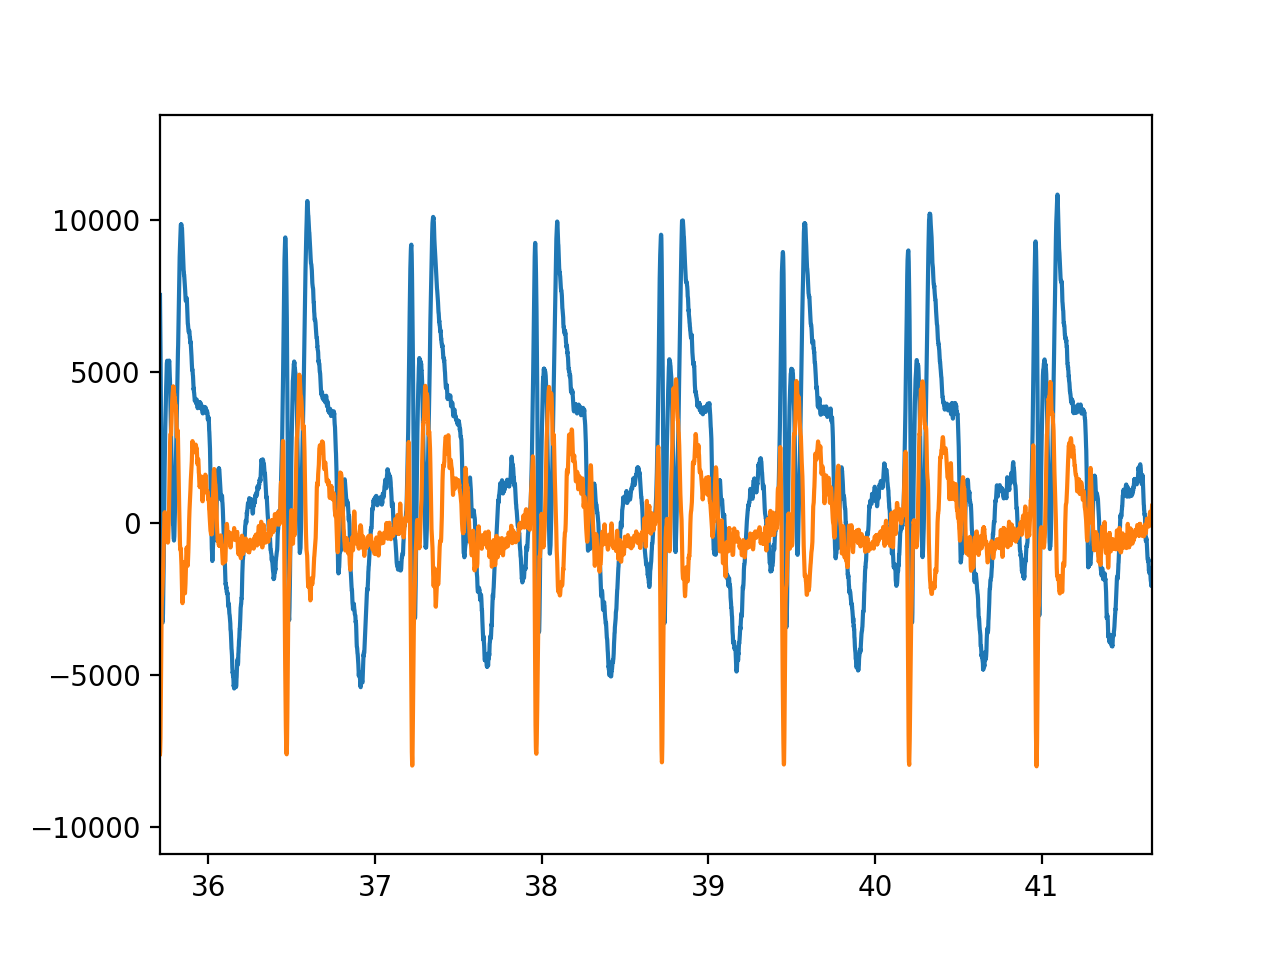

In [ ]:
# Check ECG
ecg_all = proc.load_physio(inpdir, ftype="ECG")
t_ecg_all = np.arange(ecg_all.shape[1])*tr_ecg
plt.figure()
for i in range(2):
    plt.plot(t_ecg_all, ecg_all[i,:], label = "ECG " + str(i))
plt.xlim([30,60])
plt.show()

# Plots for SCMR 2022, cardiac

In [ ]:
# Plot PT + BPT
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v2/bpt_pt_v2"
plotdir = os.getcwd()
bpt_subj1 = load_bpt(inpdir, outdir=inpdir, pfile_name=pfile_fname, get_ksp=False)
colors = ["tab:brown", "tab:green",
          "tab:red", "tab:blue"]
c = np.array([30, 26, 24, 21])
c_label = c - 16 
pt_mod = proc.get_percent_mod(np.abs(bpt[0,...]))
bpt_mod = proc.get_percent_mod(np.abs(bpt[1,...]))
data_mat = np.vstack((-1*pt_mod[:, c[0]], # PT
                      pt_mod[:, c[1]],
                      bpt_mod[:, c[2]], # BPT
                      bpt_mod[:, c[3]]))
labels = ["PT coil "+str(c_label[0]), "PT coil "+str(c_label[1]),
          "BPT coil "+str(c_label[2]), "BPT coil "+str(c_label[3])]

fig, ax = plot_fig_2(bpt_subj1, c, c_label,
                     xlim=np.array([0,4]), colors=colors,
                     start_loc=1, manual_adjust=False, v_shift=0.25, y_line=-9,
                     title = "",
                     fname="bpt_vs_pt.png",
                     plotdir=plotdir,
                    data_mat=data_mat,
                    labels=labels,
                    shift=-7,
                    l_shift=0.1)

PT exists! Reading file /mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v2/bpt_pt_v2/pt_ravel.cfl
percent mod = [ 0.55  0.21 30.44 31.63]


<IPython.core.display.Javascript object>

In [ ]:
# Plot raw BPT/PT- subject 2
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v3/bpt_pt_1min"
plotdir = os.getcwd()
bpt_subj2 = load_bpt(inpdir, outdir=inpdir, pfile_name=pfile_fname, get_ksp=False)
colors = ["tab:brown", "tab:pink",
            "tab:orange","tab:green"]
c = np.array([14, 13, 12, 5])
c_label = c 
pt_mod = proc.get_percent_mod(np.abs(bpt_subj2[0,...]))
bpt_mod = proc.get_percent_mod(np.abs(bpt_subj2[1,...]))
data_mat = np.vstack((-1*pt_mod[:, c[0]], # PT
                      pt_mod[:, c[1]],
                      bpt_mod[:, c[2]], # BPT
                      bpt_mod[:, c[3]]))
labels = ["PT coil "+str(c_label[0]), "PT coil "+str(c_label[1]),
          "BPT coil "+str(c_label[2]), "BPT coil "+str(c_label[3])]

fig, ax = plot_fig_2(bpt_subj2, c, c_label,
                     xlim=np.array([0,4]), colors=colors,
                     start_loc=1, manual_adjust=False, v_shift=0.25, y_line=-9,
                     title = "",
                     fname="bpt_vs_pt_subj2.png",
                     plotdir=plotdir,
                    data_mat=data_mat,
                    labels=labels,
                    shift=-7,
                    l_shift=0.1)

PT exists! Reading file /mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v3/bpt_pt_1min/pt_ravel.cfl
percent mod = [ 0.96  0.51  8.17 23.14]


<IPython.core.display.Javascript object>

# Figure 1 - Accelerometer concept

In [ ]:
# Load cardiac data
inpdir = "/mikRAID/sanand/pilot_tone/results/volunteer_110421/cardiac_bh"
ksp = np.squeeze(cfl.readcfl(os.path.join(inpdir,"ksp")))
img = sp.ifft(ksp, axes=(0,1))
print(img.shape)

(256, 256, 50, 32)


/mikQNAP/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


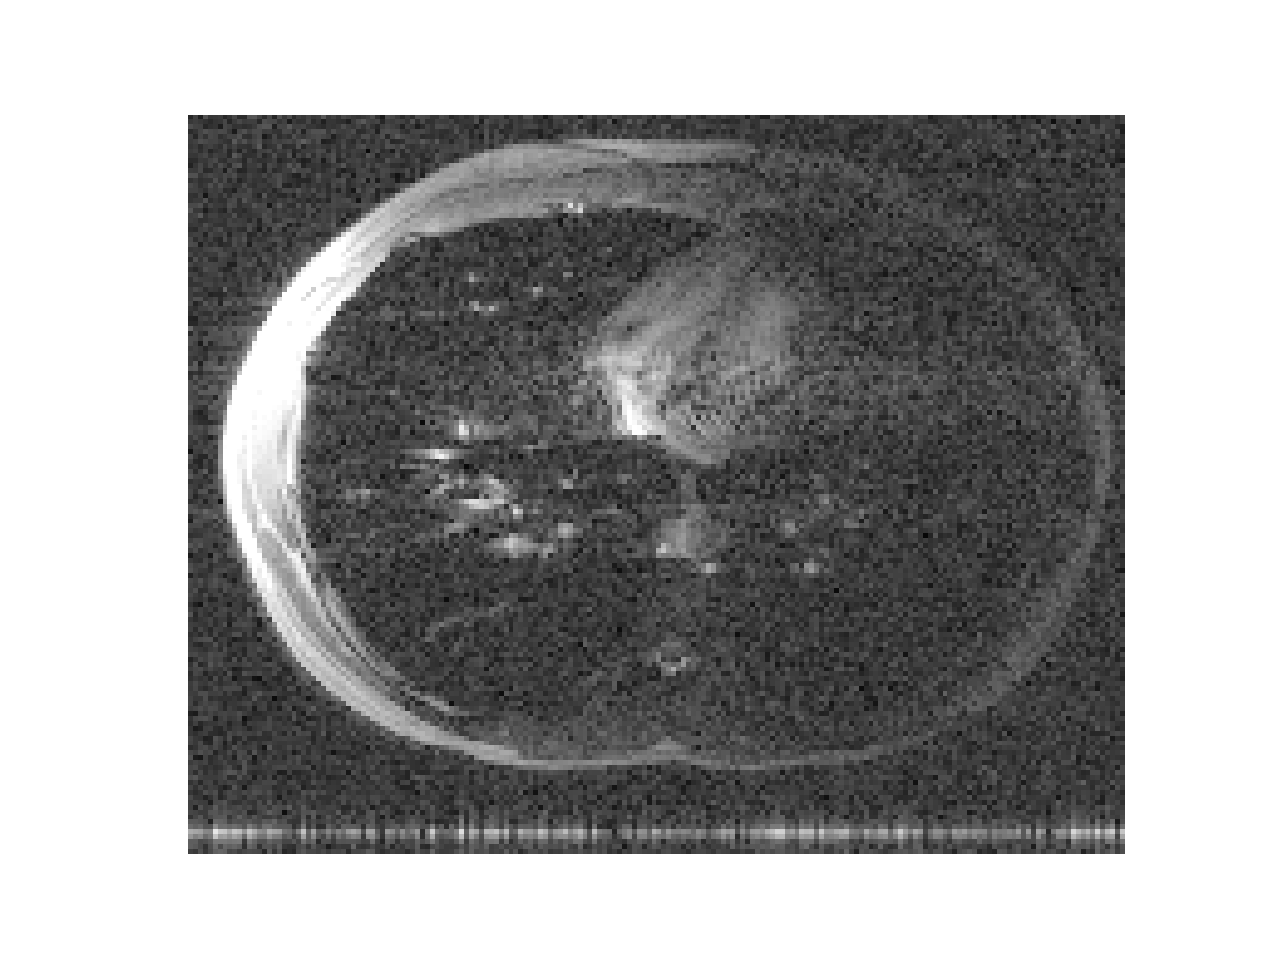

<IPython.core.display.Javascript object>


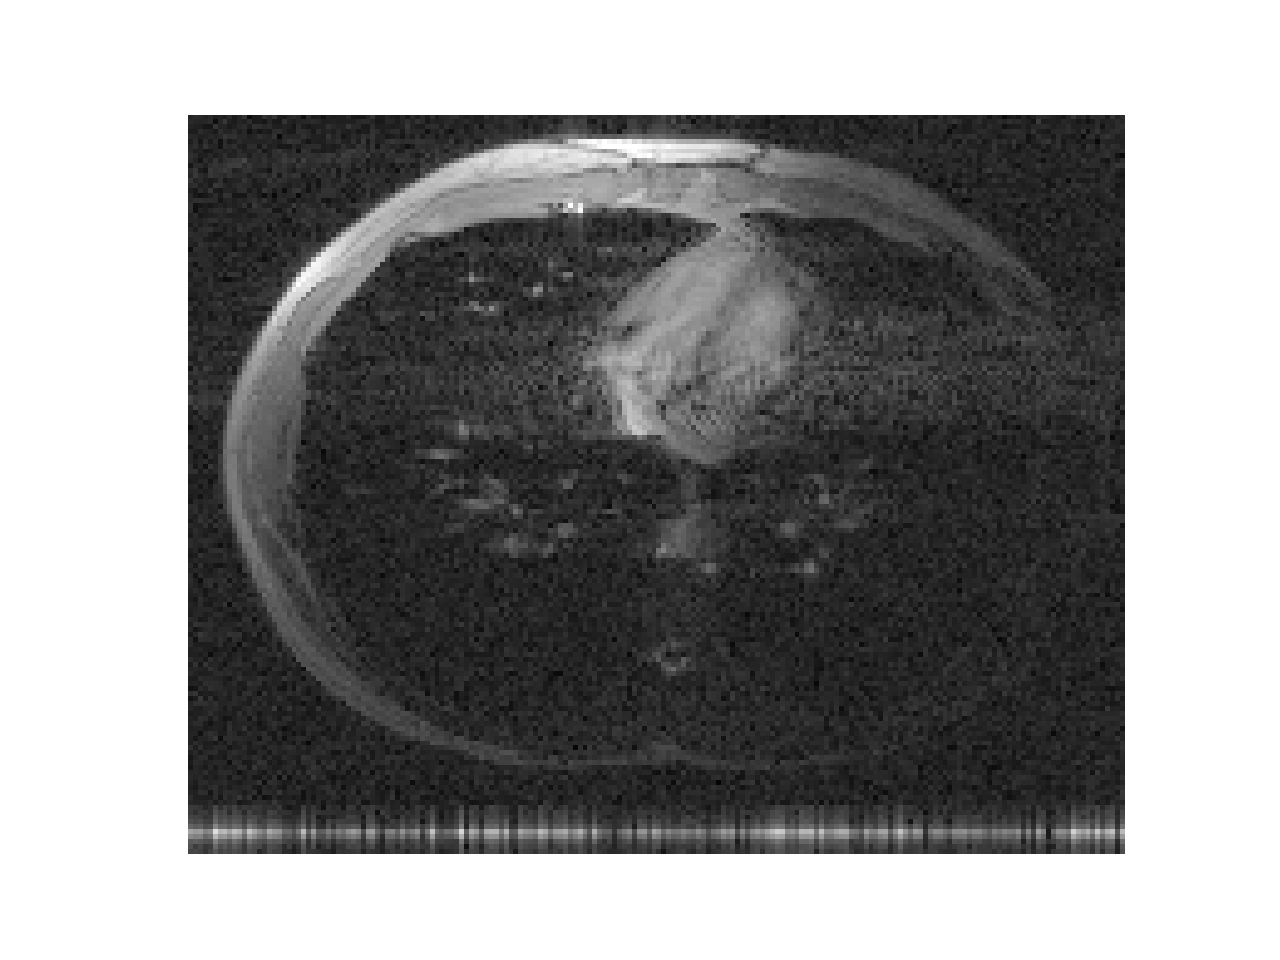

In [ ]:
# Plot cardiac images
# clims = [600,1000]
clims = np.sqrt([150,500])
for i, c in enumerate([16,17]):
    plt.figure()
#     plt.imshow(np.abs(img[50:190,30:220,0, c])**(1/2), "gray")
    # Crop out extra black space
    img1 = np.abs(img[50:190,30:220,0,c])**(1/2.5)
    img2 = np.abs(img[230:240,30:220,0,c])**(1/2.5)
    img_test = np.vstack((img1,img2))
    plt.imshow(img_test, "gray")
    plt.clim([0,clims[i]])
    plt.axis("off")
    plt.savefig(os.path.join(plotdir, "cardiac_{}.png".format(c)), transparent=True, dpi=300)
plt.show()

<IPython.core.display.Javascript object>


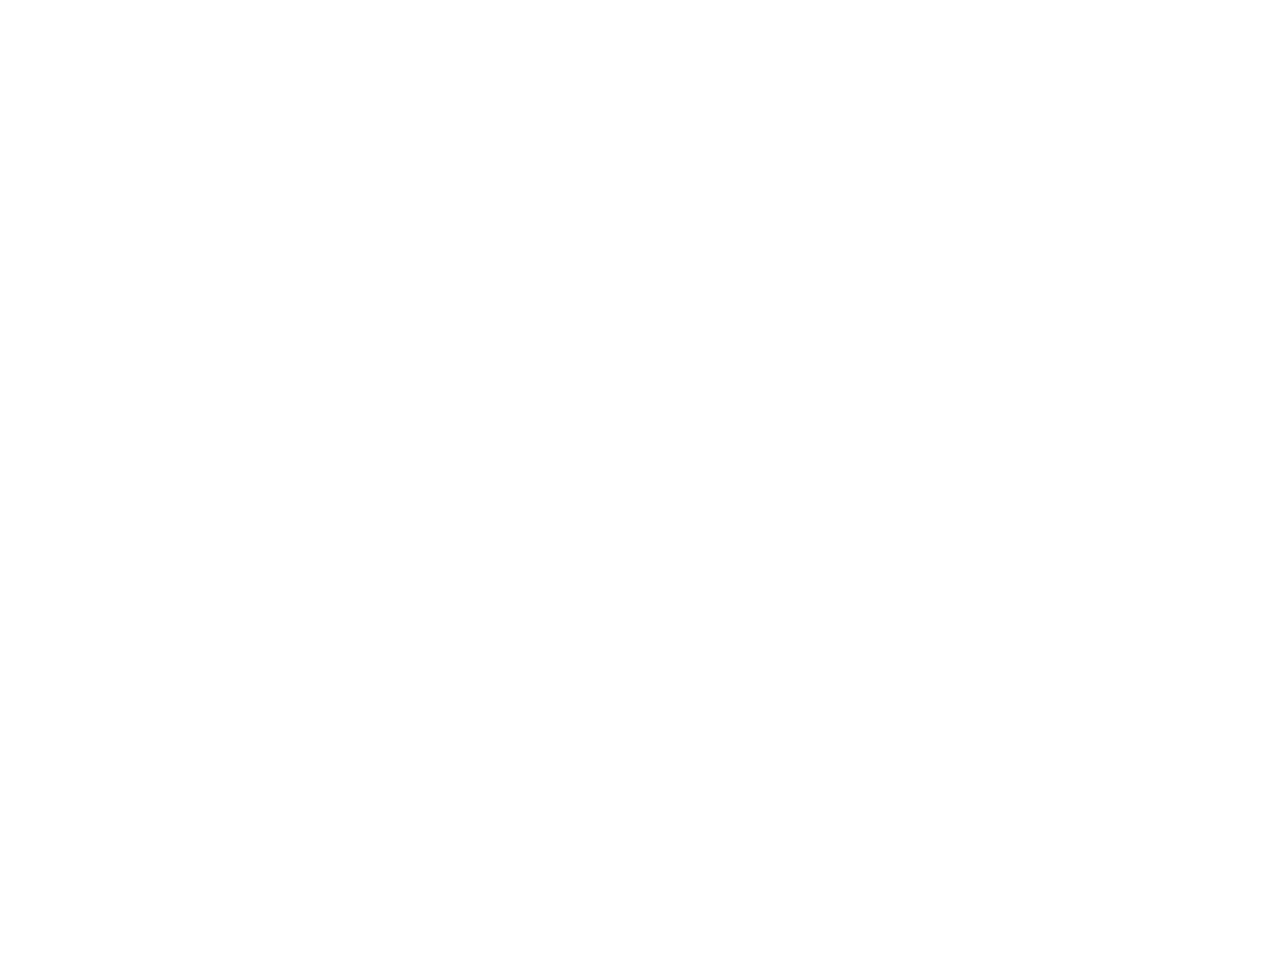

In [ ]:
# Plot accelerometer data
axes = ["x","y","z"]
colors = ["r","tab:orange","b"]
plt.figure()
for i in range(3):
    if i == 0 or i == 2:
        accel_d[:,i] *= -1
    plt.plot(t,accel_d[:,i], lw=5, c=colors[i])
    plt.xlim([1.7,2.5])
#     plt.xlim([0,1])
    plt.axis("off")
    plt.savefig(os.path.join(plotdir, "dbcg_{}.png".format(axes[i])), transparent=True, dpi=300)
    plt.clf()

<IPython.core.display.Javascript object>


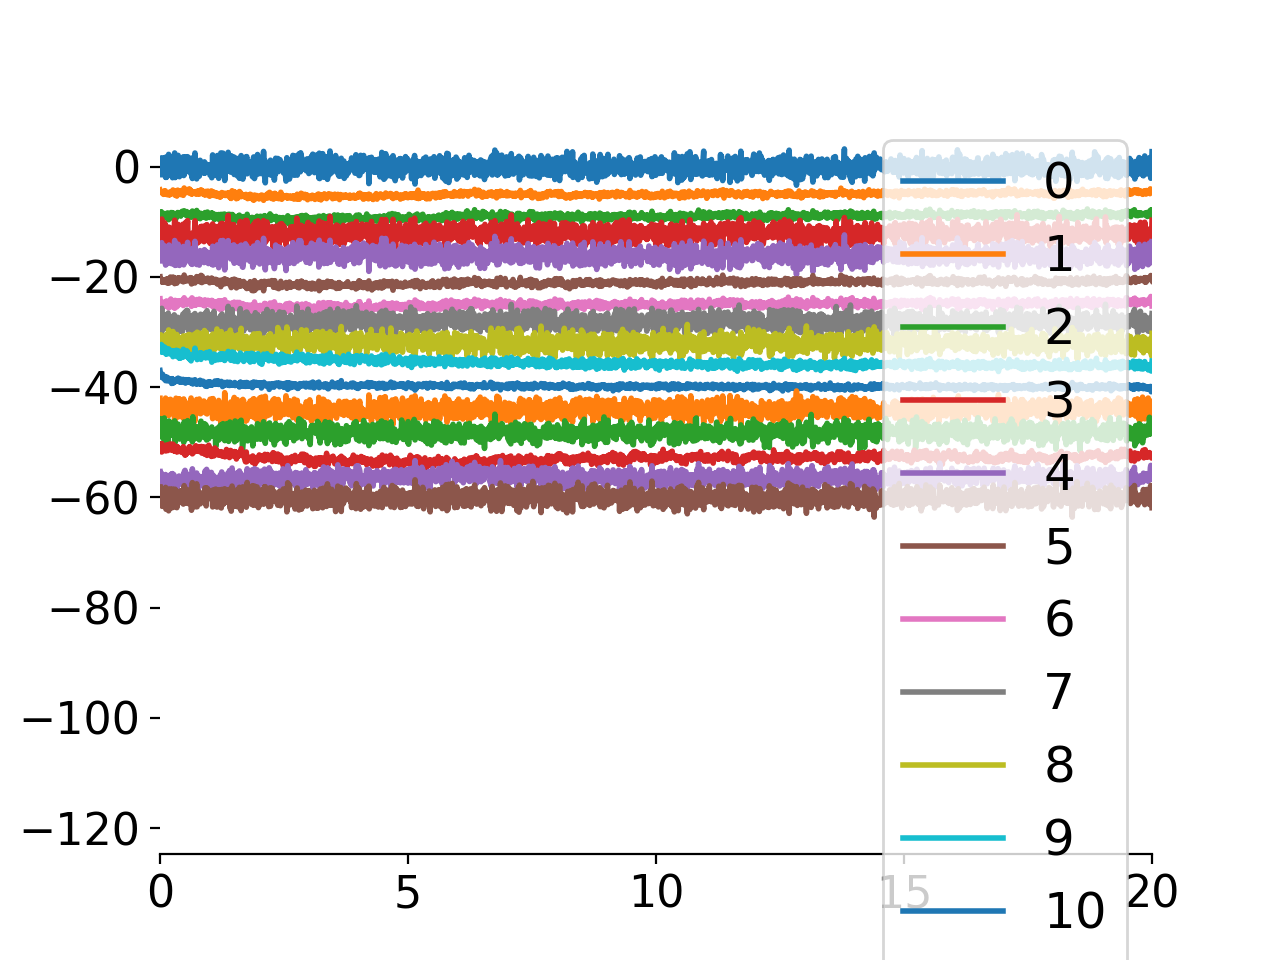

<IPython.core.display.Javascript object>


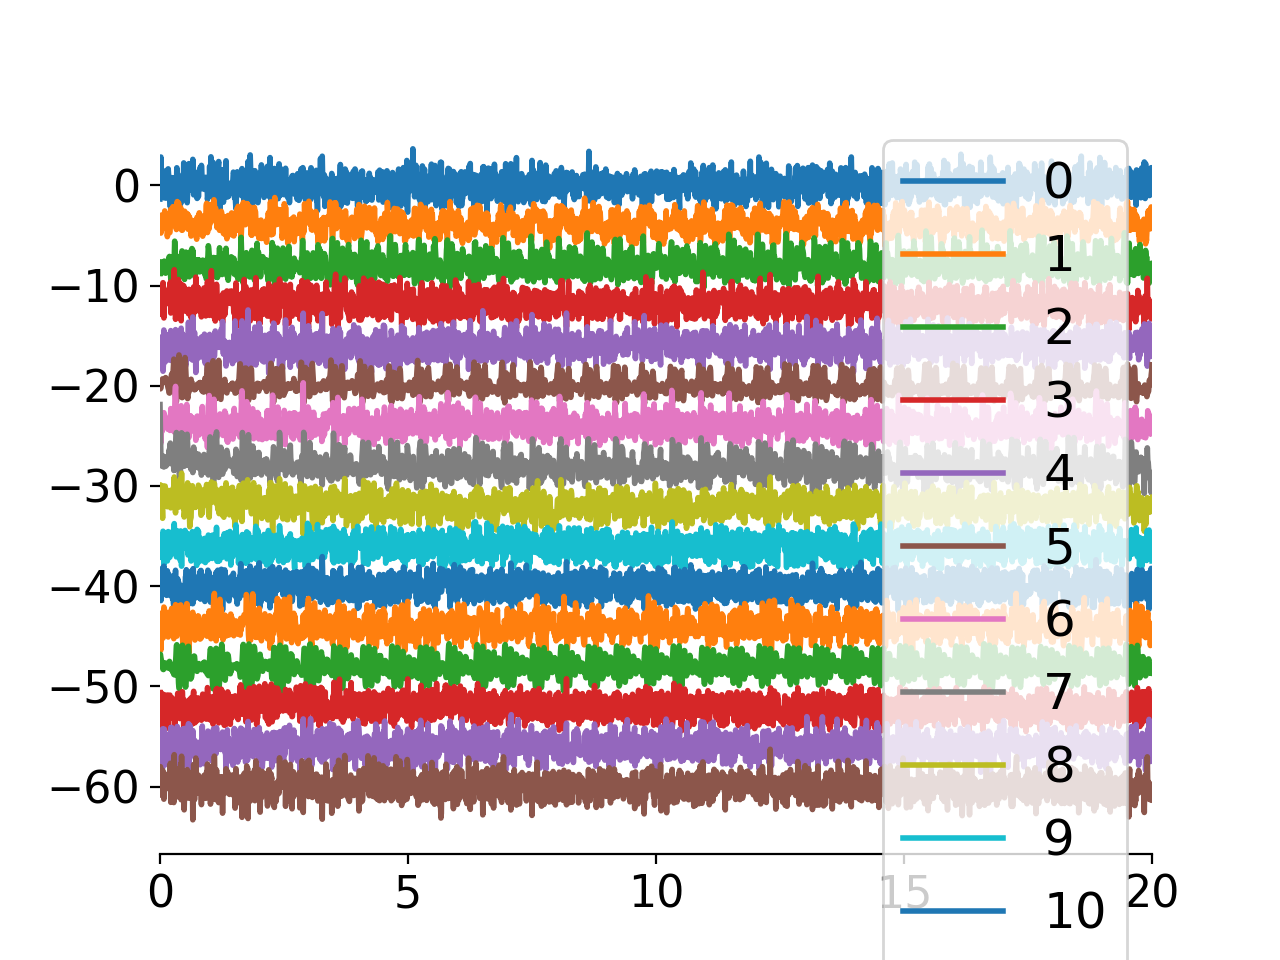

In [ ]:
# Plot raw PT/BPT
shift = -4
for i in range(2):
    plt.figure()
    plt.plot(t, proc.normalize_c(np.abs(bpt[i,...])) + shift*np.arange(bpt.shape[-1]))
    plt.xlim([0,20])
    plt.legend(np.arange(bpt.shape[-1]))

# Figure 2 - BPT/PT

In [ ]:
# Plot raw BPT/PT - subject 1
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v2/bpt_pt_v2"
plotdir = inpdir # Where plots are saved to
bpt_subj1 = load_bpt(inpdir, outdir=inpdir, pfile_name=pfile_fname, get_ksp=False)
colors = ["tab:brown", "tab:purple", "tab:red",
              "tab:red","tab:green", "tab:blue"]
c = np.array([30, 26, 24, 24, 21, 17])
c_label = c - 16
fig, ax = plot_fig_2(bpt_subj1, c, c_label,
                     xlim=np.array([0,7]), colors=colors,
                     start_loc=0.97, manual_adjust=True, v_shift=0.155, y_line=-18.5,
                     title = "Raw BPT and PT, Subject 1",
                     fname="bpt_vs_pt_v3.png",
                     plotdir=plotdir)

PT exists! Reading file /mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v2/bpt_pt_v2/pt_ravel.cfl
percent mod = [ 0.55  0.21  2.5  30.44 31.63  8.87]


<IPython.core.display.Javascript object>

In [ ]:
# Plot raw BPT/PT- subject 2
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v3/bpt_pt_1min"
plotdir = inpdir
bpt_subj2 = load_bpt(inpdir, outdir=inpdir, pfile_name=pfile_fname, get_ksp=False)
colors = ["tab:brown", "tab:pink", "tab:orange",
            "tab:orange","tab:green", "tab:red"]
c = np.array([14,13,12,12,5,8])
c_label = c
plot_fig_2(bpt_subj2, c, c_label,
           xlim=np.array([0,7]), colors=colors,
           start_loc=0.97, manual_adjust=False, v_shift=0.157, y_line=-18.5,
           title = "Raw BPT and PT, Subject 2",
           fname="bpt_vs_pt_v3_subj2.png",
           plotdir=plotdir)

ksp shape = (300, 300, 23, 16)
PT freqs = [-112.5  120. ]
percent mod = [ 0.96  0.51  2.38  8.17 23.14  7.25]


/mikQNAP/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(<Figure size 1000x1000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1848018f98>)

# Figure 3 - Accel vs Physio

<IPython.core.display.Javascript object>


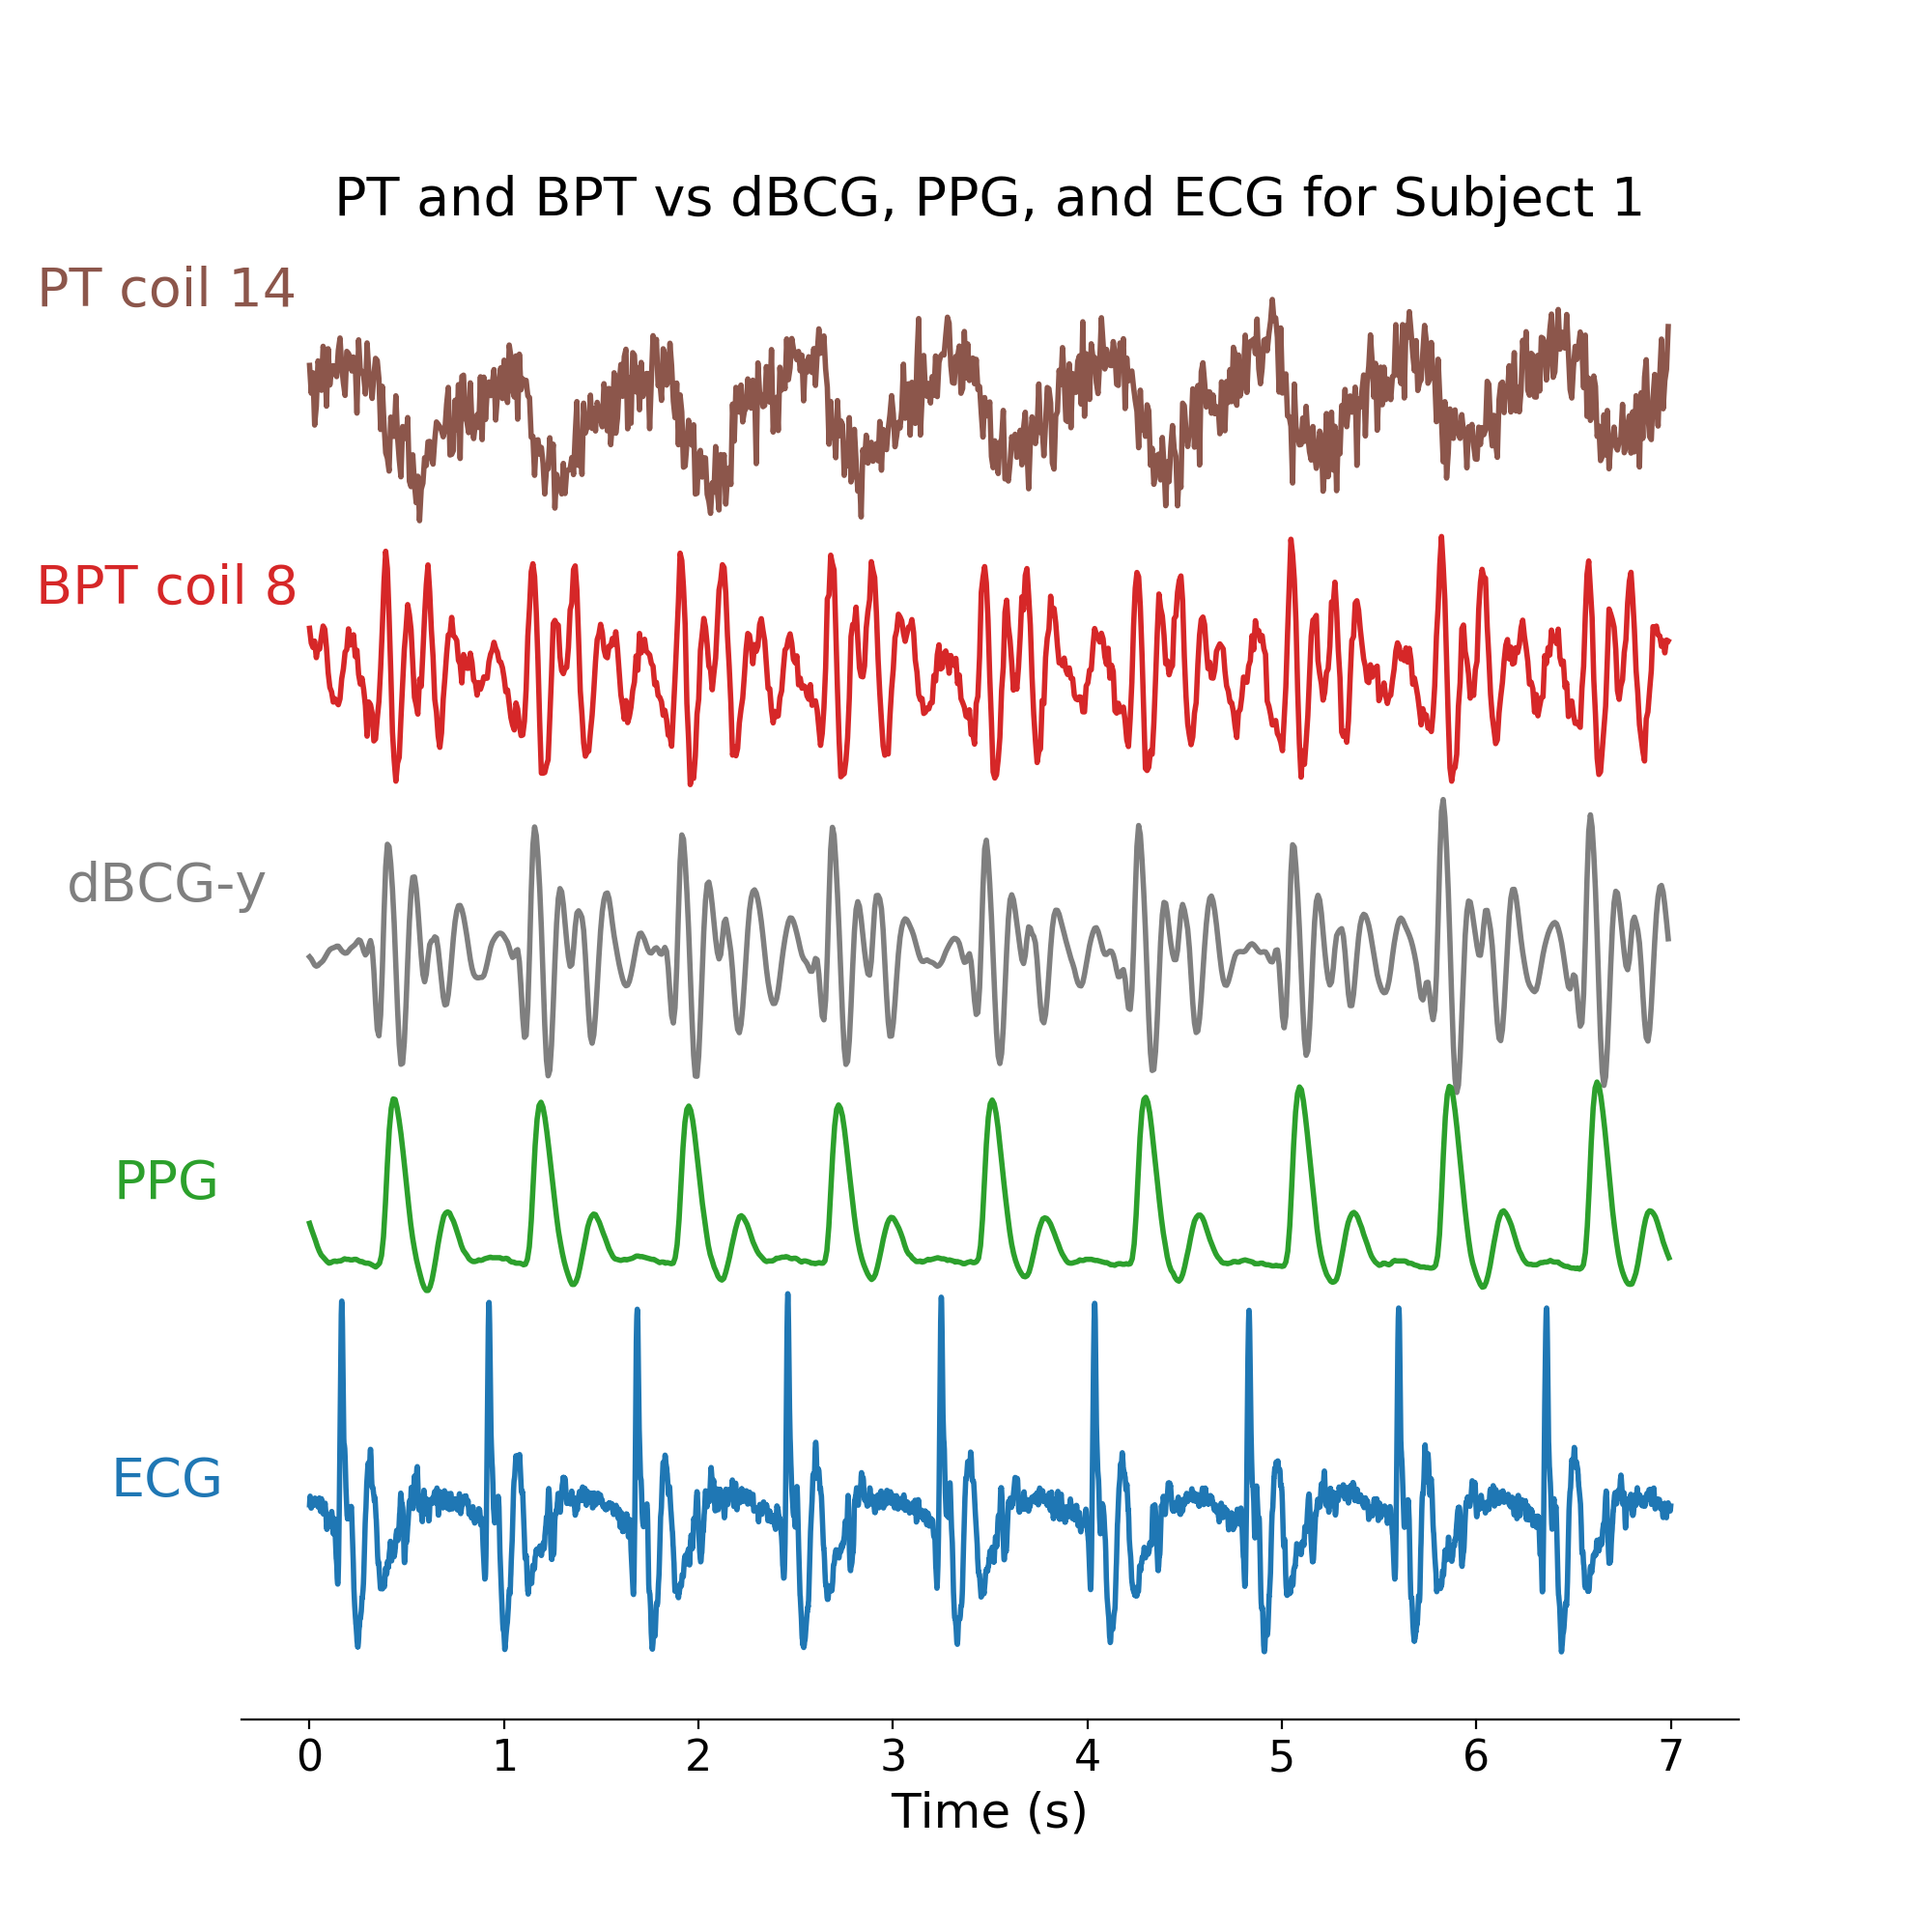

In [ ]:
# Plot Figure 3 - Accelerometer vs physio
# Subject 1
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v2/bpt_pt_v2"
plotdir = inpdir
# Get ECG and PPG
[ecg, ppg] = proc.get_physio_waveforms(inpdir, bpt_len=bpt.shape[1]*tr,
                                       tr_ppg=tr_ppg, tr_ecg=tr_ecg,from_front=True,
                                       index=1)
# Get accel data
accel, t_accel = get_accel_data(inpdir)
# Integrate accel -> displacement
accel_d = get_accel_d(accel, tr=tr, cutoff=cutoff)
# Plot BPT
c = [30, 24]
bpt_stack = np.vstack((proc.normalize(np.abs(bpt_subj1[0,:,c[0]]), var=True),
                      proc.normalize(np.abs(bpt_subj1[1,:,c[1]]), var=True))).T

labels = ["PT coil {}".format(c[0] - 16), "BPT coil {}".format(c[1] - 16),
          "dBCG-y", "PPG", "ECG"]
colors = ["tab:brown", "tab:red","tab:gray", "tab:green", "tab:blue"]


fig, ax = plot_bpt_physio(bpt_stack, accel_d[:,1],
                          ppg, -1*ecg, tr=tr, c=c, norm_var=True,
                          shift=-6, t_end=7, figsize=(10,10),
                          labels=labels, colors=colors, v_shift=0.2,
                          plotdir=plotdir,
                          title="PT and BPT vs dBCG, PPG, and ECG for Subject 1")

<IPython.core.display.Javascript object>


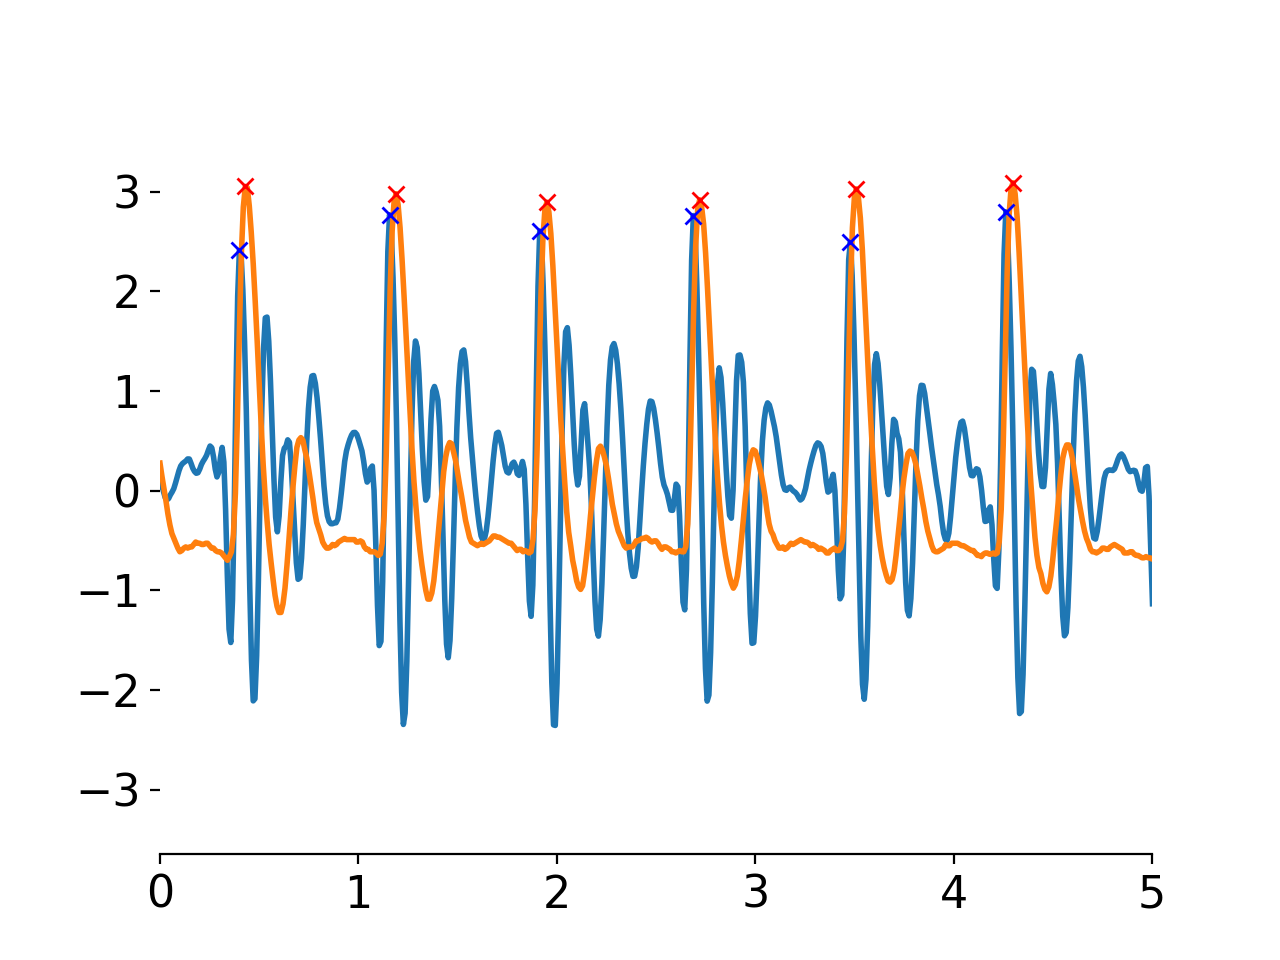

<IPython.core.display.Javascript object>


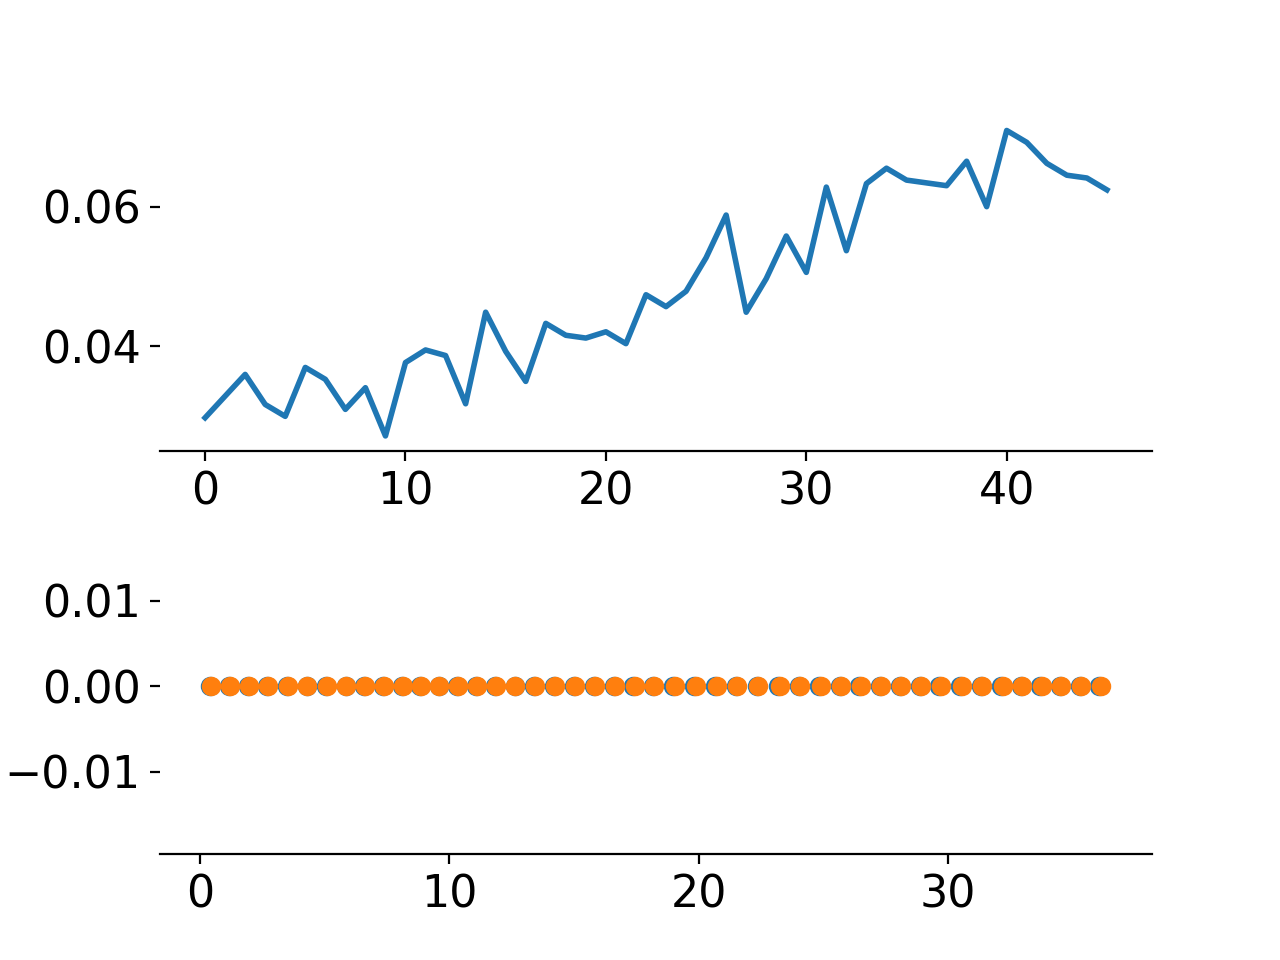

Mean time difference = 48.115217391305855ms, std = 12.964180877414657ms
[ 0.4002  1.1571  1.914   2.6883  3.48    4.263   5.0547  5.829   6.5859
  7.3428  8.0823  8.8305  9.5613 10.3182 11.0751 11.8407 12.615  13.4067
 14.1984 14.9988 15.8079 16.5996 17.3826 18.1743 18.9921 19.8273 20.6712
 21.5151 22.3503 23.1942 24.0294 24.8472 25.6563 26.4567 27.2745 28.0662
 28.8666 29.667  30.4935 31.32   32.1291 32.9208 33.7038 34.4955 35.2959
 36.0876]
[ 0.43  1.19  1.95  2.72  3.51  4.3   5.09  5.86  6.62  7.37  8.12  8.87
  9.6  10.35 11.12 11.88 12.65 13.45 14.24 15.04 15.85 16.64 17.43 18.22
 19.04 19.88 20.73 21.56 22.4  23.25 24.08 24.91 25.71 26.52 27.34 28.13
 28.93 29.73 30.56 31.38 32.2  32.99 33.77 34.56 35.36 36.15]


In [ ]:
# Compute delay of dBCG-y relative to PPG - For Wei
dbcgy = proc.normalize(accel_d[:,1])
t = np.arange(dbcgy.shape[0])*tr
t_ppg = np.arange(ppg.shape[0])*10e-3
ppg_norm = proc.normalize(ppg) 
plt.figure()
plt.plot(t, dbcgy)
plt.plot(t_ppg, ppg_norm)
# Find peaks
locs_ppg = detect_peaks(ppg_norm, mph=2)
locs_bcg = detect_peaks(dbcgy, mph=2)
plt.plot(t_ppg[locs_ppg], ppg_norm[locs_ppg], 'x', c='r')
plt.plot(t[locs_bcg], dbcgy[locs_bcg] ,'x', c='b')
plt.xlim([0,5])
plt.show()

# Plot time difference
t_diff = t_ppg[locs_ppg] - t[locs_bcg]
plt.figure()
plt.subplot(211)
plt.plot(t_diff)
plt.subplot(212)
plt.scatter(t[locs_bcg],np.zeros(locs_bcg.shape[0]))
plt.scatter(t_ppg[locs_ppg],np.zeros(locs_ppg.shape[0]))
print("Mean time difference = {}ms, std = {}ms".format(np.mean(t_diff)*1e3, np.std(t_diff)*1e3))

print(t[locs_bcg])
print(t_ppg[locs_ppg])

<IPython.core.display.Javascript object>


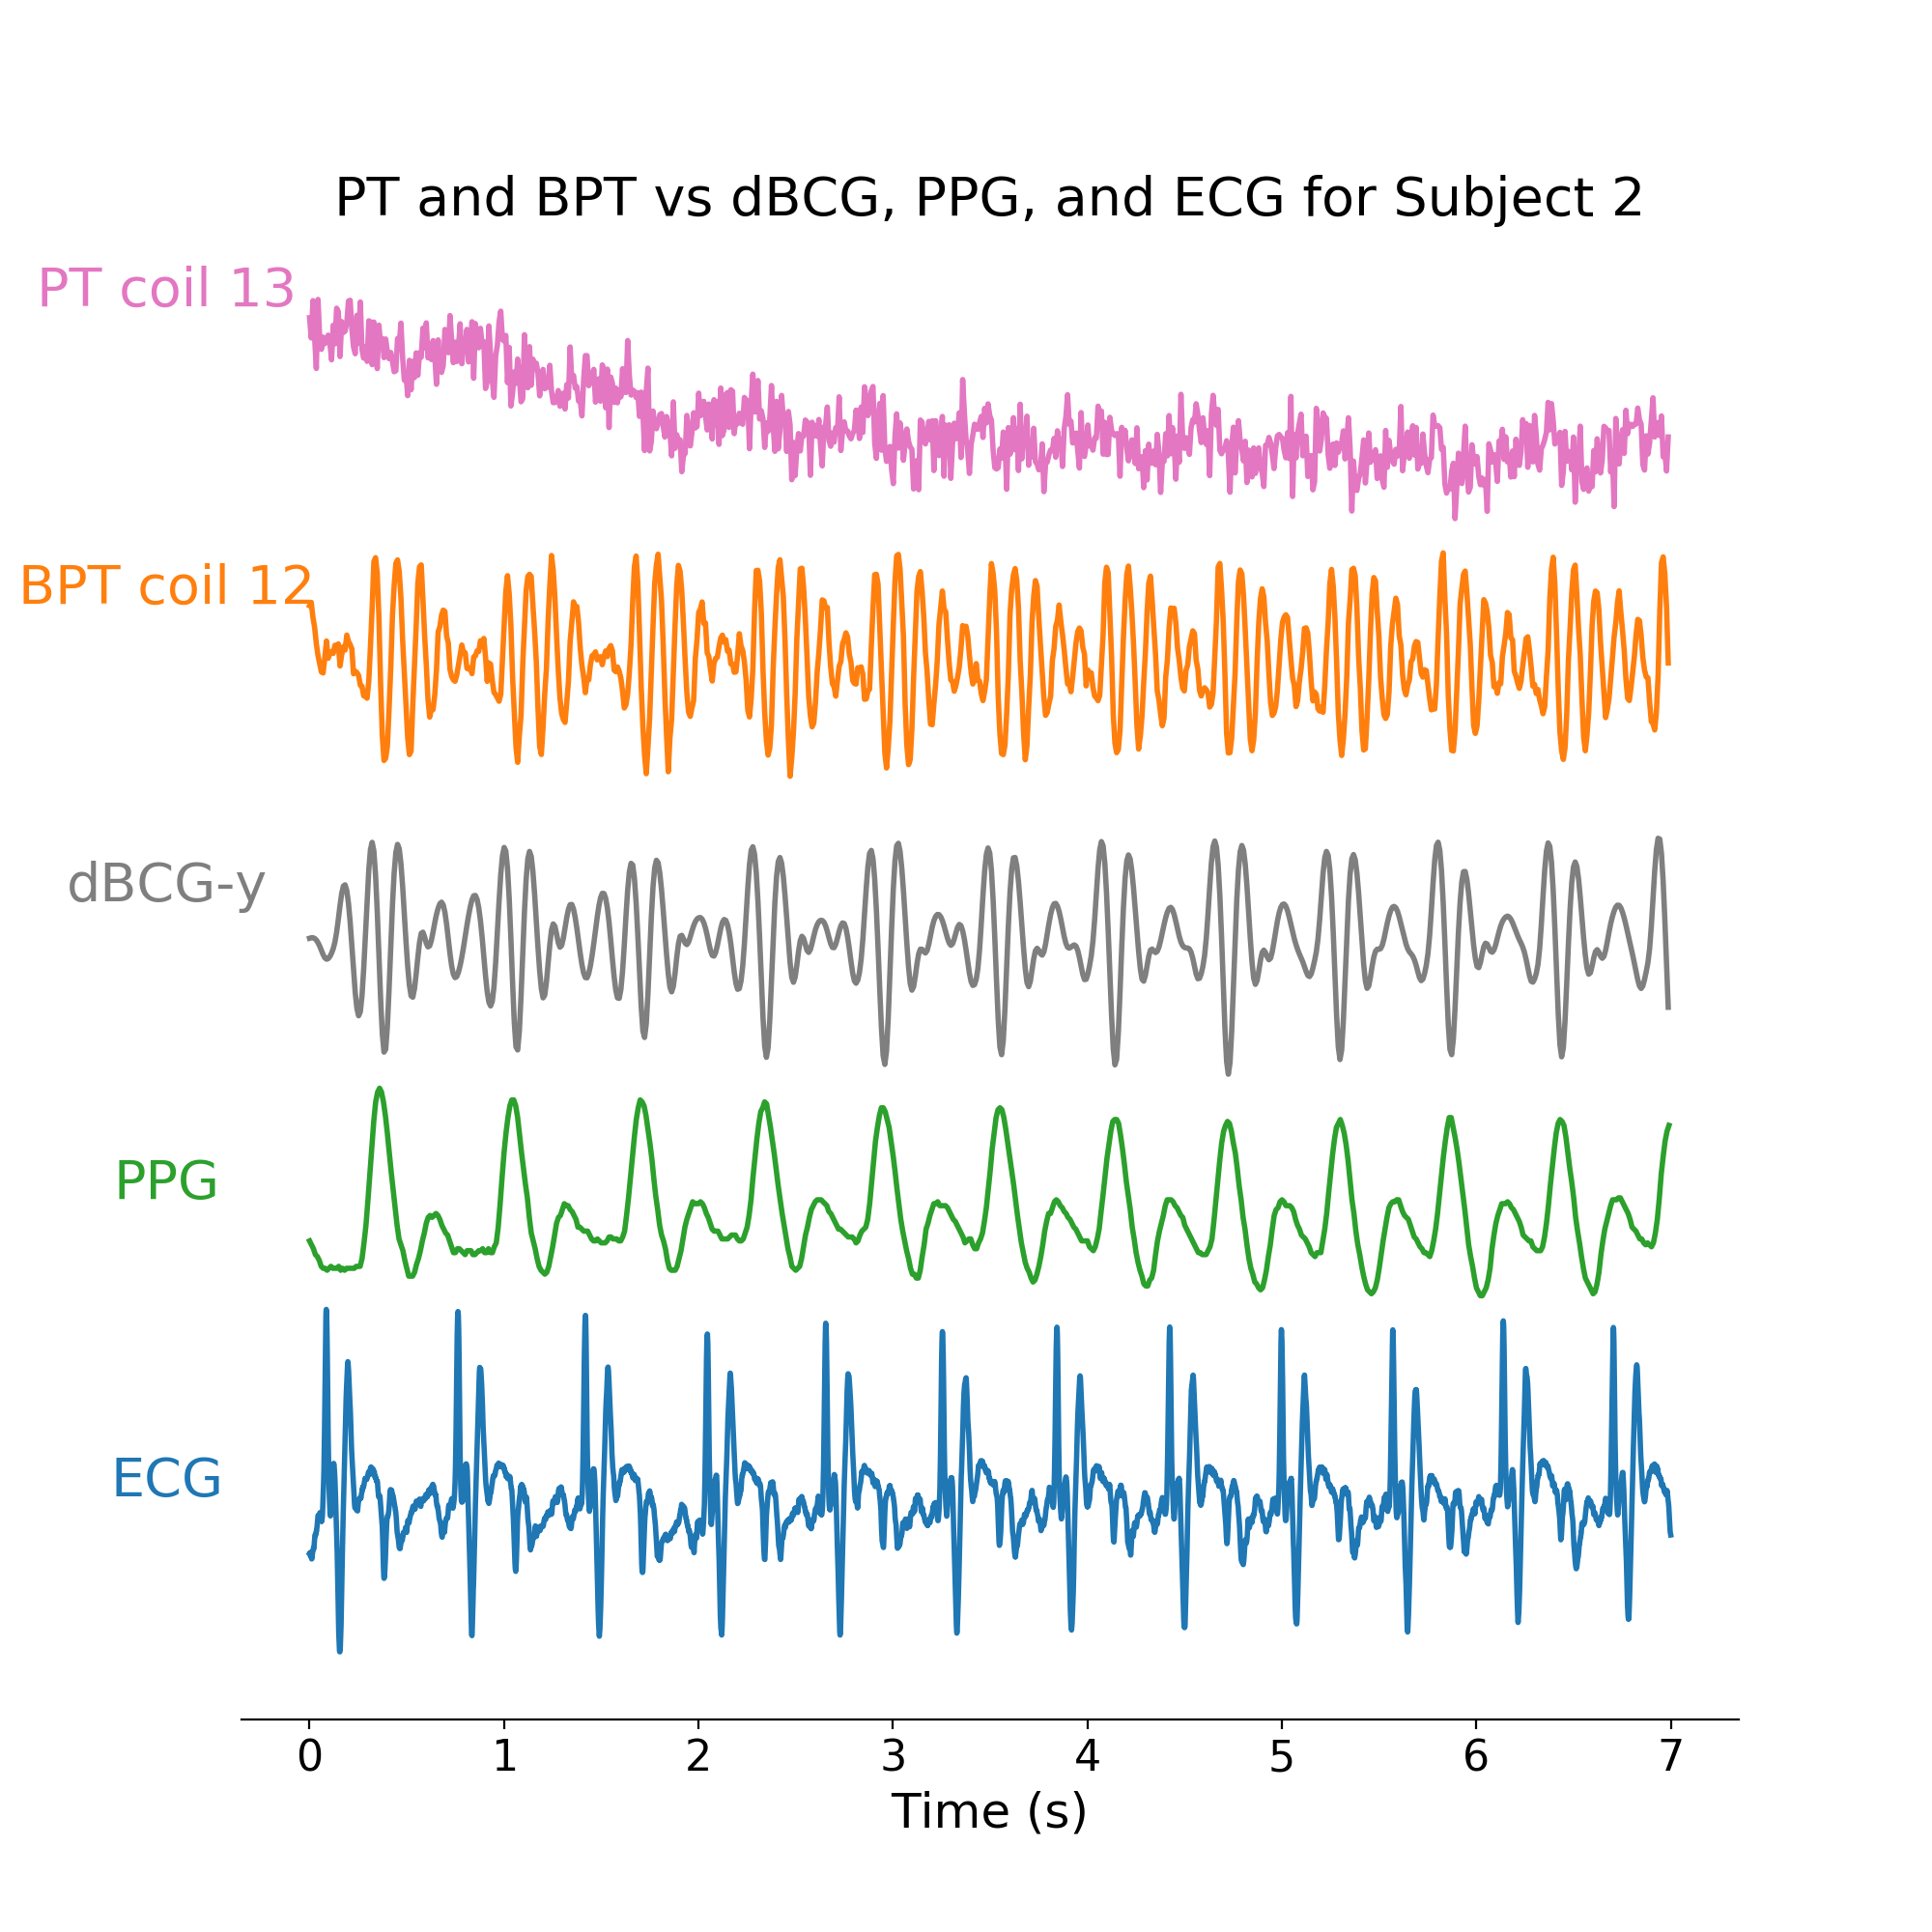

In [ ]:
# Subject 2
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v3/bpt_pt_1min"
plotdir = inpdir
# Get ECG and PPG
[ecg, ppg] = proc.get_physio_waveforms(inpdir, bpt_len=bpt_subj2.shape[1]*tr,
                                       tr_ppg=tr_ppg, tr_ecg=tr_ecg,from_front=True,
                                       index=0)
accel, t_accel = get_accel_data(inpdir)
# Integrate accel -> displacement
accel_d = get_accel_d(accel, tr=tr, cutoff=cutoff)

# Plot BPT
c = [13, 12]
bpt_stack = np.vstack((proc.normalize(np.abs(bpt_subj2[0,:,c[0]]), var=True),
                      proc.normalize(np.abs(bpt_subj2[1,:,c[1]]), var=True))).T

# Plot BPT
labels = ["PT coil {}".format(c[0]), "BPT coil {}".format(c[1]),"dBCG-y", "PPG", "ECG"]
colors = ["tab:pink", "tab:orange", "tab:gray", "tab:green", "tab:blue"]
c = 12
fig, ax = plot_bpt_physio(bpt_stack, accel_d[:,1],
                ppg, ecg, tr=tr, c=c, norm_var=True,
                shift=-6, t_end=5, figsize=(10,10),
                labels=labels, colors=colors, v_shift=0.2,
                plotdir=plotdir,
                fname="bpt_vs_physio_subj2.png",
                title="PT and BPT vs dBCG, PPG, and ECG for Subject 2")
# ax.set_ylim([-30,10])

# Figure 4 - Linear combination of BPT vs dBCG

In [ ]:
# Plot Figure 3 - Accelerometer vs physio
# Subject 1
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v2/bpt_pt_v2"
plotdir = inpdir

# Get accel data
accel, t_accel = get_accel_data(inpdir)
# Integrate accel -> displacement
accel_d = get_accel_d(accel, tr=tr, cutoff=cutoff)

# Fit each displacement separately
# Normalize the BPT
bpt_inp = proc.normalize_c(np.abs(bpt_subj1[1,...]))
accel_inp = proc.normalize_c(accel_d)
bpt_d = get_bpt_d(accel_inp, bpt_inp)
# Filter
bpt_filt = proc.filter_c(bpt_d, cutoff=np.array([1,15]), tr=tr)

# Compute correlations
corr = np.array([np.corrcoef(bpt_filt[:,i], accel_inp[:,i])[0,1] for i in range(3)])
print("Correlation = {}".format(np.round(corr,2)))

# Plot
data_mat = np.vstack((bpt_filt[:,0],
                      accel_inp[:,0],
                      bpt_filt[:,1],
                      accel_inp[:,1],
                      bpt_filt[:,2],
                      accel_inp[:,2]))
xlim = np.array([0,5])
labels = ["BPT-dBCG-x", "dBCG-x", "BPT-dBCG-y", "dBCG-y","BPT-dBCG-z", "dBCG-z"]
colors = ["darkcyan", "darkkhaki", "purple", "tab:gray", "maroon","black"]
fig, ax = plot_all_data(data_mat, labels=labels, colors=colors,
                        figsize=(10,10), xlim=xlim,
                        norm_var=False, shift=-7,
                        plotdir=plotdir, mod=False,
                        v_shift=0.15, y_line=-9.1,
                        title="BPT-dBCG vs dBCG for Subject 1",
                        fname="bpt_vs_accel.png",
                        set_yline=False)
# ax.axhline(-9.1, ls='--', c='k')
# ax.axhline(-20, ls='--', c='k')

/mikQNAP/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:206: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/mikQNAP/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Correlation = [0.81 0.81 0.58]


In [ ]:
# Zoomed in figure
t = np.arange(bpt_d.shape[0])*tr
shift = -8
plt.figure()
plt.plot(t,bpt_filt[:,1], color="purple")
plt.plot(t,accel_inp[:,1] + shift, color="tab:gray")
plt.xlim([0.9,1.7])
plt.axis("off")
plt.savefig(os.path.join(plotdir,"bcg_zoomed.png"), transparent=True)

/mikQNAP/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


In [ ]:
# Plot Figure 3 - Accelerometer vs physio
# Subject 2
inpdir = "/mikRAID/sanand/pilot_tone/bcg/volunteer_110422_v3/bpt_pt_1min"
plotdir = inpdir

# Get accel data
accel, t_accel = get_accel_data(inpdir)
# Integrate accel -> displacement
accel_d = get_accel_d(accel, tr=tr, cutoff=cutoff)

# Fit each displacement separately
# Normalize the BPT
bpt_inp = proc.normalize_c(np.abs(bpt_subj2[1,...]))
accel_inp = proc.normalize_c(accel_d)
bpt_d = get_bpt_d(accel_inp, bpt_inp)
# Filter
# bpt_filt = proc.filter_c(bpt_d, cutoff=np.array([1,15]), tr=tr)
bpt_filt = proc.filter_c(bpt_d, cutoff=15, tr=tr)

# Compute correlations
corr = np.array([np.corrcoef(bpt_filt[:,i], accel_inp[:,i])[0,1] for i in range(3)])
print("Correlation = {}".format(np.round(corr,2)))

# Plot
data_mat = np.vstack((bpt_d[:,0],
                      accel_inp[:,0],
                      bpt_d[:,1],
                      accel_inp[:,1],
                      bpt_d[:,2],
                      accel_inp[:,2]))
xlim = np.array([0.1,7])
labels = ["BPT-dBCG-x", "dBCG-x", "BPT-dBCG-y", "dBCG-y","BPT-dBCG-z", "dBCG-z"]
colors = ["darkcyan", "darkkhaki", "purple", "tab:gray", "maroon","black"]
fig, ax = plot_all_data(data_mat, labels=labels, colors=colors,
                        figsize=(10,10), xlim=xlim,
                        norm_var=False, shift=-7,
                        plotdir=plotdir, mod=False,
                        v_shift=0.157, y_line=-9.1,
                        title="BPT-dBCG vs dBCG for Subject 2",
                        fname="bpt_vs_accel_subj2.png", set_yline=False)
# ax.axhline(-8, ls='--', c='k')
# ax.axhline(-20, ls='--', c='k')

/mikQNAP/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:206: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/mikQNAP/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Correlation = [0.71 0.85 0.78]


In [ ]:
# Zoomed in figure
t = np.arange(bpt_d.shape[0])*tr
shift = -8
plt.figure()
plt.plot(t,bpt_filt[:,1], color="purple")
plt.plot(t,accel_inp[:,1] + shift, color="tab:gray")
plt.xlim([0.75,1.5])
plt.axis("off")
plt.savefig(os.path.join(plotdir,"bcg_zoomed_subj2.png"), transparent=True)

/mikQNAP/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
